In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [179]:
# Path to the cleaned data
data_path="C://Users//Dimitri//Desktop//ENSAE3A//Apprentissage en ligne//OnlinePortfolio//TreatedData//DataNyse.csv"
# Frequence of rebalancing the portfolio
ndays_rebal = 30

In [180]:
# Load the data
data_nyse = pd.read_csv(data_path, index_col="Date")
# Convert data index to datetime
data_nyse.index = pd.to_datetime(data_nyse.index)
# Print the data for a quick check
print(data_nyse)

               nwl     fhn       cmi     cma     wfc     cms      ups     nem  \
Date                                                                            
2001-09-21  17.690  29.537    6.4215  43.127  16.944  15.085   40.068  19.856   
2001-09-24  18.018  29.955    6.8668  44.278  17.225  15.085   40.161  19.260   
2001-09-25  18.181  30.751    6.9695  45.840  17.372  14.887   41.359  19.565   
2001-09-26  18.392  31.850    6.7469  45.112  17.423  14.494   39.861  20.832   
2001-09-27  18.852  32.147    6.8838  45.967  17.431  14.287   40.083  21.083   
2001-09-28  18.945  32.113    7.0640  46.753  17.735  14.368   41.900  21.039   
2001-10-01  19.075  31.814    6.8754  46.376  17.735  14.368   40.826  22.134   
2001-10-02  19.347  32.331    7.1667  45.744  17.796  14.454   40.387  21.891   
2001-10-03  19.895  31.859    7.2006  45.608  17.859  14.793   41.195  20.581   
2001-10-04  19.903  30.760    7.2605  45.325  17.654  15.085   41.917  20.562   
2001-10-05  20.112  29.935  

In [181]:
# Get the returns for every ndays_rebal and select only every ndays_rebal-th date
data_returns = data_nyse.pct_change(ndays_rebal).ix[::ndays_rebal, :]
data_returns = data_returns.shift(-1)

## Wealth factor
The following function computes the wealth factor of a strategy determined by a set of weigths $q_{i, t}$. Let $x_{i, t}$ be the returns, $N$ the number of assets and $n$ the number of periods, the wealth factor is given by :
$$ \prod_{t=1}^n \sum_{i=1}^N x_{i, t} q_{i, t} $$

In [182]:
def wealth_factor(x, q, n):
    """
    Compute the wealth factor for a given strategy q
    
    Args:
        x (pandas.core.frame.DataFrame) : the dataframe of 1 + returns
        q (pandas.core.frame.DataFrame) : the weights for the strategy
        n (int) : number of periods to compute the wealth factor on
    Returns:
        float. The wealth factor for the strategy q
    """
    wealth_coefs = (x * q).sum(axis=1)
    log_wealth_coefs = wealth_coefs.apply(np.log)
    log_wealth_factor = log_wealth_coefs.cumsum()
    return np.exp(log_wealth_factor)

## Internal regret

In [183]:
def switched_strategy(pvec, i, j):
    """
    Compute the i to j transformed strategy weight vector
    
    Args:
        pvec (pandas.core.series.Series) : the original weight vector
        i (str) : the stock which weight should be allocated to j
        j (str) : the stock keeping its weight and getting i's moreover
    Returns:
        pandas.core.series.Series. The modified weight vector
    """
    switched = pvec.copy()
    switched[j] += switched[i] 
    switched[i] = 0
    return switched

In [184]:
def no_switch_regret(pvec, xvec, i, j):
    """
    Compute the i to j component to regret for a single vector
    
    Args:
        pvec (pandas.core.series.Series) : the original weight vector
        xvec (pandas.core.series.Series) : the vector of 1 + returns
        i (str) : the stock which weight should be allocated to j
        j (str) : the stock keeping its weight and getting i's moreover
    Returns:
        float. The regret component
    """
    switched = switched_strategy(pvec, i, j)
    return np.log((switched * xvec).sum()) -  np.log((pvec * xvec).sum())

In [193]:
def pairs_of_stocks(p):
    stocks_pairs = list(itertools.product(p.columns, p.columns))
    stocks_pairs_str = []
    for pair in stocks_pairs:
        if pair[0] != pair[1]:
            stocks_pairs_str.append(pair[0] + "/" + pair[1])
    return stock_pairs_str

In [194]:
def no_switch_regret_tab(p, x):
    stocks_pairs_str = pairs_of_stocks(p)
    regret_tab = pd.DataFrame(index=p.index, columns=stocks_pairs_str)
    for t in p.index:
        for pair in stocks_pairs_str :
            stock1, stock2 = pair.split("/")[0], pair.split("/")[1]
            regret_tab.loc[t, pair] = no_switch_regret(p.loc[t, :], x.loc[t, :], stock1, stock2)
    return regret_tab

In [195]:
def internal_regret_tab(p, x):
    r_tab = no_switch_regret_tab(p, x).cumsum().max(axis=1)
    return r_tab

## Exp weights coefs
For a given set of weights at time $t-1$, will compute the vector of actualization of the weights at time $t$ which is given by the components :
$$ \frac{p_{i, t} \exp \left( \frac{\eta x_{i, t}} {p_t x_t} \right)}{\sum_{j=1}^N p_{j, t} \exp \left( \frac{\eta x_{j, t}} {p_t x_t} \right)} $$

In [187]:
def exp_weights(pvec, xvec, eta):
    """
    Computes the vector of actualization of the weights for the EG strategy
    
    Args:
        pvec (pandas.core.series.Series) : the vector of previous weights
        xvec (pandas.core.series.Series) : the vector of previous 1 + returns
        eta (float) : eta parameter
    Returns:
        pandas.core.series.Series. The vector of actualization of weights for the EG strategy
    """
    norm_coef = (pvec * xvec).sum()
    wvec = pd.Series(index=pvec.index)
    for i in pvec.index:
        wvec[i] = pvec[i] * np.exp (eta * xvec[i] / norm_coef)
    return wvec / wvec.sum()

In [188]:
def weights_eg(xtab, eta, pinit):
    """
    Compute the weights for the EG strategy
    
    Args:
        xtab (pandas.core.frame.DataFrame) : the data frame of returns
        eta (float) : the eta parameter
        pinit (pandas.core.series.Series) : the series of initial weights, we must have pinit.index = xtab.columns
    """
    wtab = pd.DataFrame(index=xtab.index, columns=xtab.columns)
    for t in range(0, w.shape[0]):
        if t==0:
            wtab.iloc[t, :] = pinit
        else :
            coefs = exp_weights(wtab.iloc[t-1, :], xtab.iloc[t-1, :], eta)
            wtab.iloc[t, :] = coefs
    return wtab

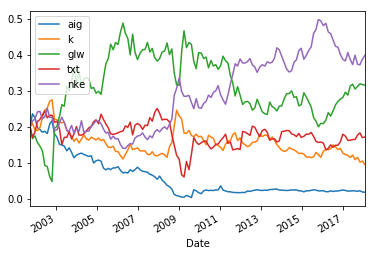

In [189]:
# Test for weights_eg
x = 1 + data_returns.iloc[:200, 10:15]
pinit = pd.Series(index=x.columns, data=1/len(x.columns))
w = weights_eg(x, 1, pinit)
w.plot()
plt.show()

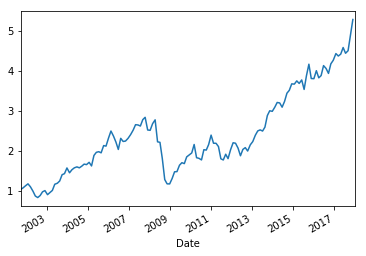

In [190]:
# Test for wealth factor on the EG strategy
w_fact = wealth_factor(x, w, 10)
w_fact.plot()
plt.show()

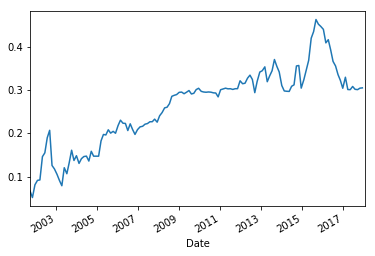

In [191]:
# Test for internal regret
ir = internal_regret_tab(w, x)
ir.plot()
plt.show()

## BP1EXP and BP1POL

In [ ]:
def delta_update_exp(delta_prev, pvec_new, xvec_new, eta):
    norm_coef = 0
    delta = pd.Series(index=delta_prev.index)
    for 
    
    

In [192]:
def induced_matrix(delta, pvec):
    A = pd.DataFrame(index=pvec.index, columns=pvec.index)
    for m in pvec.index:
        for i in pvec.index:
            if i != m:
                A.loc[m, i] = delta.loc[m + "/" + i]
        A.loc[m, m] = A.loc[:, m].sum()
    return A

In [ ]:
def induced_weights(delta, pvec)